In [1]:
#Import Library
from torchvision import datasets
import torchvision.transforms as transforms
import collections
from torchvision import utils
from torch.utils.data import DataLoader
from torchsummary import summary
from torch import nn
from torch import optim
import torch
import torchvision
import matplotlib.pyplot as plt
import random

d:\classification_test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hasnan-mhr (hasnanmr). Use `wandb login --relogin` to force relogin


True

In [4]:
run = wandb.init(
    project="trashnet-classification",
    notes="My first experiment",
    tags=["baseline", "resnet50"],
    entity="hasnanmr"
)

# config = dict(
#     epochs=15,
#     classes=6,
#     batch_size=64,
#     learning_rate=0.0001,
#     dataset="Trashnet",
#     architecture="Resnet")

In [5]:
from torchvision.models import resnet50, ResNet50_Weights

def get_model():
    "A simple model"
    model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    for param in model_resnet.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_resnet.fc.in_features
    model_resnet.fc = nn.Linear(num_ftrs, 6)  

    model_resnet = model_resnet.to(device)
    return model_resnet

In [6]:
def log_image_table(images, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["image", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(images.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

## Data Loader

In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

image_directory = r'dataset-original\dataset-original'
dataset = ImageFolder(image_directory, transform=ToTensor())

In [8]:
dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: dataset-original\dataset-original
    StandardTransform
Transform: ToTensor()

In [9]:
from torch.utils.data import DataLoader, random_split, Dataset

# Custom Dataset to apply transformations after loading
class TransformDataset(Dataset):
    def __init__(self, dataset, classes, transform=None):
        self.dataset = dataset
        self.classes = classes
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Load the dataset from the directory
image_directory = r'dataset-original\dataset-original'
dataset = ImageFolder(image_directory, transform=ToTensor())

# Print the total number of images in the dataset
print(f'Total number of images in the dataset: {len(dataset)}')

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print sizes of each split
print(f'Train dataset size after split: {len(train_dataset)}')
print(f'Validation dataset size after split: {len(val_dataset)}')
print(f'Test dataset size after split: {len(test_dataset)}')


Total number of images in the dataset: 2527
Train dataset size after split: 2021
Validation dataset size after split: 252
Test dataset size after split: 254


In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #resize images
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))        
])

In [11]:
train_dataset = TransformDataset(train_dataset, dataset.classes, transform=transform)
val_dataset = TransformDataset(val_dataset, dataset.classes, transform=transform)
test_dataset = TransformDataset(test_dataset, dataset.classes, transform=transform)

# Create DataLoaders for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
def validate_model(model, valid_dl, loss_func, log_images=False, batch_idx=0):
    "Compute performance of the model on the validation dataset and log a wandb.Table"
    model.eval()
    val_loss = 0.
    with torch.inference_mode():
        correct = 0
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(device), labels.to(device)

            # Forward pass ➡
            outputs = model(images)
            val_loss += loss_func(outputs, labels)*labels.size(0)

            # Compute accuracy and accumulate
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            # Log one batch of images to the dashboard, always same batch_idx.
            if i==batch_idx and log_images:
                log_image_table(images, predicted, labels, outputs.softmax(dim=1))
    return val_loss / len(valid_dl.dataset), correct / len(valid_dl.dataset)

In [13]:
import math
for _ in range(15):
    # 🐝 initialise a wandb run
    wandb.init(
        project="trashnet-classification",
        config={
            "epochs": 15,
            "batch_size": 32,
            "lr": 1e-4,
            })
    
    # Copy your config 
    config = wandb.config

    # Get the data
    train_dl = train_loader
    valid_dl = val_loader
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)
    
    # A simple MLP model
    model = get_model()

    wandb.watch(model, log="all")

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.NAdam(model.parameters(), lr=config.lr)

   # Training
    example_ct = 0
    step_ct = 0
    for epoch in range(config.epochs):
        model.train()
        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
            example_ct += len(images)
            metrics = {"train/train_loss": train_loss, 
                       "train/epoch": (step + 1 + (n_steps_per_epoch * epoch)) / n_steps_per_epoch, 
                       "train/example_ct": example_ct}
            
            if step + 1 < n_steps_per_epoch:
                # 🐝 Log train metrics to wandb 
                wandb.log(metrics)
                
            step_ct += 1

        val_loss, accuracy = validate_model(model, valid_dl, loss_func, log_images=(epoch==(config.epochs-1)))

        # 🐝 Log train and validation metrics to wandb
        val_metrics = {"val/val_loss": val_loss, 
                       "val/val_accuracy": accuracy}
        wandb.log({**metrics, **val_metrics})
        
        print(f"Train Loss: {train_loss:.3f}, Valid Loss: {val_loss:3f}, Accuracy: {accuracy:.2f}")

    # # If you had a test set, this is how you could log it as a Summary metric
    # wandb.summary['test_accuracy'] = 0.8

    # 🐝 Close your wandb run 
    wandb.finish()

Train Loss: 1.788, Valid Loss: 1.546363, Accuracy: 0.51


## Exploration Image Analysis

In [ ]:
# Verify the splits
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')

Training set size: 2021
Validation set size: 252
Test set size: 254


In [ ]:
# Check if the dataset has the 'classes' attribute
if hasattr(train_loader.dataset, 'classes'):
    # Print the class labels
    print(f'Class labels: {train_loader.dataset.classes}')
else:
    print("The dataset does not have a 'classes' attribute")

Class labels: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# from collections import Counter
# # Function to count labels in a DataLoader
# def count_labels(loader):
#     counter = Counter()
#     for _, labels in loader:
#         counter.update(labels.tolist())
#     return counter

# # Count labels in each DataLoader
# train_labels_count = count_labels(train_loader)
# val_labels_count = count_labels(val_loader)
# test_labels_count = count_labels(test_loader)

# # Print label counts
# print(f'Training set label counts: {train_labels_count}')
# print(f'Validation set label counts: {val_labels_count}')
# print(f'Test set label counts: {test_labels_count}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55886865..1.8200003].


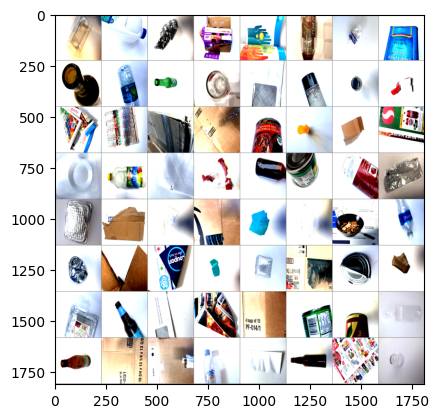

plastic plastic metal cardboard paper glass plastic metal glass plastic glass glass paper glass metal paper paper paper cardboard cardboard metal plastic cardboard paper plastic plastic paper paper glass metal glass trash metal cardboard paper cardboard paper paper cardboard plastic metal cardboard paper trash plastic cardboard metal paper plastic glass paper paper cardboard metal metal plastic glass cardboard cardboard plastic paper glass paper glass


In [ ]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels using the classes attribute from the original dataset
print(' '.join(f'{train_dataset.classes[labels[j]]:5s}' for j in range(len(labels))))

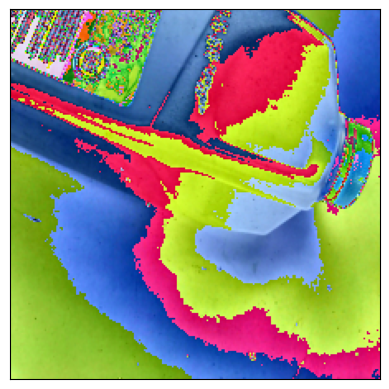

In [ ]:
import torchvision.transforms.functional as F
import numpy as np
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

# Extract the image tensor from the dataset
image, label = train_loader.dataset[1]
show(image)

## Modelling

In [ ]:
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim


# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         # Define the convolution layers
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=0) # Output: (224 - 3 + 2*0)/1 + 1 = 222
#         self.pool = nn.MaxPool2d(2, 2)              # Output: 222 / 2 = 111
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=0) # Output: (111 - 3 + 2*0)/1 + 1 = 109
#         self.conv3 = nn.Conv2d(32, 32, 3, padding=0) # Output: (109 - 3 + 2*0)/1 + 1 = 107
#         self.conv4 = nn.Conv2d(32, 64, 3, padding=0) # Output: (107 - 3 + 2*0)/1 + 1 = 105
#         self.pool2 = nn.MaxPool2d(2, 2)             # Output: 105 / 2 = 52 (rounded down)

#         # Calculate the size of the flattened features after last pooling
#         feature_size = 64 * 52 * 52  # flatten for fully connected

#         # Define the fully connected layers
#         self.fc1 = nn.Linear(feature_size, 100)
#         self.dropout1 = nn.Dropout(p=0.4)
#         self.fc2 = nn.Linear(100, 80)
#         self.fc3 = nn.Linear(80, 6)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = F.relu(self.conv2(x))
#         x = F.relu(self.conv3(x))
#         x = self.pool2(F.relu(self.conv4(x)))
#         x = torch.flatten(x, 1)  # flatten all dimensions except the batch
#         x = F.relu(self.fc1(x))
#         x = self.dropout1(x)
#         x = F.relu(self.fc2(x))
#         x = self.dropout1(x)
#         x = self.fc3(x)
#         return x
    
# net = Net().to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.NAdam(net.parameters(), lr=0.0001)

In [ ]:
# from torchvision.models import resnet50, ResNet50_Weights

# model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# for param in model_resnet.parameters():
#     param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_resnet.fc.in_features
# model_resnet.fc = nn.Linear(num_ftrs, 6)  #mengganti jumlah classifier sesuai output kelas

# model_resnet = model_resnet.to(device)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.0005)

In [ ]:
# def calculate_accuracy(outputs, labels):
#     _, predicted = torch.max(outputs.data, 1)
#     correct = (predicted == labels).sum().item()
#     total = labels.size(0)
#     return correct / total

In [ ]:
# train_losses, val_losses, train_accs, val_accs = [], [], [], []

# for epoch in range(15):  # loop over the dataset multiple times
#     model_resnet.train()
#     running_loss, running_acc = 0.0, 0.0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model_resnet(inputs)
#         loss = loss_fn(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         running_acc += calculate_accuracy(outputs, labels)
#     train_losses.append(running_loss / len(train_loader))
#     train_accs.append(running_acc / len(train_loader))

#     model_resnet.eval()
#     val_loss, val_acc = 0.0, 0.0
#     all_preds = []
#     all_labels = []
#     with torch.no_grad():
#         for inputs, labels in val_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model_resnet(inputs)
#             loss = loss_fn(outputs, labels)
#             val_loss += loss.item()
#             val_acc += calculate_accuracy(outputs, labels)
#             _, preds = torch.max(outputs, 1)  
#             all_preds.extend(preds.cpu().numpy())  
#             all_labels.extend(labels.cpu().numpy())  
#     val_losses.append(val_loss / len(val_loader))
#     val_accs.append(val_acc / len(val_loader))
    

#     print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.2f}, Train Acc: {train_accs[-1]:.2f}, Val Loss: {val_losses[-1]:.2f}, Val Acc: {val_accs[-1]:.2f}')

Epoch 1, Train Loss: 1.48, Train Acc: 0.49, Val Loss: 1.24, Val Acc: 0.71
Epoch 2, Train Loss: 1.07, Train Acc: 0.76, Val Loss: 0.98, Val Acc: 0.78
Epoch 3, Train Loss: 0.85, Train Acc: 0.81, Val Loss: 0.83, Val Acc: 0.80
Epoch 4, Train Loss: 0.72, Train Acc: 0.83, Val Loss: 0.74, Val Acc: 0.81
Epoch 5, Train Loss: 0.64, Train Acc: 0.86, Val Loss: 0.68, Val Acc: 0.82
Epoch 6, Train Loss: 0.57, Train Acc: 0.87, Val Loss: 0.63, Val Acc: 0.83
Epoch 7, Train Loss: 0.52, Train Acc: 0.88, Val Loss: 0.59, Val Acc: 0.84
Epoch 8, Train Loss: 0.48, Train Acc: 0.89, Val Loss: 0.56, Val Acc: 0.84
Epoch 9, Train Loss: 0.44, Train Acc: 0.90, Val Loss: 0.54, Val Acc: 0.86
Epoch 10, Train Loss: 0.42, Train Acc: 0.90, Val Loss: 0.52, Val Acc: 0.86
Epoch 11, Train Loss: 0.39, Train Acc: 0.91, Val Loss: 0.50, Val Acc: 0.87
Epoch 12, Train Loss: 0.37, Train Acc: 0.92, Val Loss: 0.48, Val Acc: 0.87
Epoch 13, Train Loss: 0.35, Train Acc: 0.93, Val Loss: 0.47, Val Acc: 0.87
Epoch 14, Train Loss: 0.33, Train 

In [ ]:
# def train_one_epoch(epoch, model, criterion, optimizer, data_loader, device):
#     model.train()
#     running_loss, running_acc = 0.0, 0.0
#     for inputs, labels in data_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#         running_acc += calculate_accuracy(outputs, labels)
#     return running_loss / len(data_loader), running_acc / len(data_loader)

# def validate(model, criterion, data_loader, device):
#     model.eval()
#     val_loss, val_acc = 0.0, 0.0
#     with torch.no_grad():
#         for inputs, labels in data_loader:
#             inputs, labels = inputs.to(device), labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
#             val_acc += calculate_accuracy(outputs, labels)
#     return val_loss / len(data_loader), val_acc / len(data_loader)

# with torch.profiler.profile(
#     activities=[
#         torch.profiler.ProfilerActivity.CPU,
#         torch.profiler.ProfilerActivity.CUDA,
#     ],  
#     schedule=torch.profiler.schedule(
#         wait=1,
#         warmup=1,
#         active=3,
#         repeat=2
#     ),
#     on_trace_ready=torch.profiler.tensorboard_trace_handler('./log')
# ) as p:
#     for epoch in range(10):
#         train_loss, train_acc = train_one_epoch(epoch, net, criterion, optimizer, train_loader, device)
#         val_loss, val_acc = validate(net, criterion, val_loader, device)
#         p.step()  # Step the profiler
#         print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.2f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.2f}, Val Acc: {val_acc:.2f}')

In [ ]:
# import matplotlib.pyplot as plt
# # Plot training dan validation loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_loss, label = 'training_loss')
# plt.plot(val_loss, label='Validation Loss')
# plt.title('Training and Validation Loss per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

NameError: name 'train_loss' is not defined

<Figure size 1000x500 with 0 Axes>